# Attention Walmart Shoppers
### A Walmart retail analysis

The data was originally retrieved from:
 -   https://www.kaggle.com/rutuspatel/retail-analysis-with-walmart-sales-data
 - https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

### Data Dictionary

| Target       |  Data Type       | Description                     |
|--------------|------------------|---------------------------------|
| Weekly_Sales |   float64        | Sales in USD per week by store  |


| Column        |  Data Type       | Description                                      |  
|---------------|------------------|--------------------------------------------------|
| Store         |     int64        | unique identifier for store  (1-45)              |
| Date          |     object       | Date of transaction                              |
| Holiday_Flag  |     int64        | indicator of a Holiday week (boolean)            |
| Temperature   |     float64      | temperature in Farenheight                       |
| Fuel_Price    |     float64      | cost of fuel(in USD) in region                   |
| CPI           |     float64      | Prevailing consumer price index, cost of goods   |
| Unemployment  |     float64      | Prevailing unemployment rate                     |

## Goal:
- to predict weekly sales price for a store

## Think about...
- What is your goal?
- what is your TARGET? drivers for that target?
- what is one oberservation? what does one row from your dataset represent?

## Daily meetings
- standup doc
- shared knowledge doc

### Three important Questions
- what did you work on since we last talked?
- what are you planning on working on next?
- what are your blockers?

In [1]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#math
from scipy import stats
import math

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score

#custom modules
import wrangle
import new_wrangle

#remove warnings
import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid black"> </hr>

# Acquire

In [2]:
#bring in walmart data using new_wrangle.py
df= new_wrangle.acquire_data()

In [3]:
#take a look
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,A,151315
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,A,151315
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,A,151315
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,A,151315
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,A,151315


In [4]:
#check for nulls, dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
 8   Type          6435 non-null   object 
 9   Size          6435 non-null   int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 553.0+ KB


<hr style="border:2px solid black"> </hr>

# Prepare

In [5]:
#import the cleaned data using new_wrangle.py
df= new_wrangle.wrangle_walmart()

In [6]:
#make sure that all columns are created
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   store_id            6435 non-null   object 
 1   weekly_sales        6435 non-null   float64
 2   holiday_flag        6435 non-null   int64  
 3   temperature         6435 non-null   int64  
 4   fuel_price          6435 non-null   float64
 5   CPI                 6435 non-null   float64
 6   unemployment        6435 non-null   float64
 7   store_type          6435 non-null   object 
 8   store_size          6435 non-null   int64  
 9   month               6435 non-null   object 
 10  year                6435 non-null   int64  
 11  quarter             6435 non-null   int64  
 12  weekday             6435 non-null   object 
 13  week_of_year        6435 non-null   int64  
 14  deflated_series     6435 non-null   float64
 15  sales_delta_weekly  6435 non-null   f

In [7]:
#take a look at the data
df.tail()

,store_id,weekly_sales,holiday_flag,temperature,fuel_price,CPI,unemployment,store_type,store_size,month,...,pre_christmas,tax_season,season,holiday_name,last_year_sales,last_week_sales,christmas,labor_day,super_bowl,thanksgiving
Date,,,,,,,,,,,,,,,,,,,,,
2012-10-26,25,688940.94,0,56,3.88,216.152,7.293,B,128107,October,...,0,0,Fall,no_holiday,724443.97,685531.85,0,0,0,0
2012-10-26,5,319550.77,0,71,3.51,224.038,5.422,C,34875,October,...,0,0,Fall,no_holiday,307035.11,313358.15,0,0,0,0
2012-10-26,40,921264.52,0,49,3.92,138.728,4.145,A,155083,October,...,0,0,Fall,no_holiday,941675.95,918170.50,0,0,0,0
2012-10-26,18,1127516.25,0,56,3.92,138.728,8.243,B,120653,October,...,0,0,Fall,no_holiday,1106642.63,1048706.75,0,0,0,0
2012-10-26,45,760281.43,0,58,3.88,192.309,8.667,B,118221,October,...,0,0,Fall,no_holiday,781694.57,718125.53,0,0,0,0


In [8]:
df.isnull().sum()

store_id                 0
weekly_sales             0
holiday_flag             0
temperature              0
fuel_price               0
CPI                      0
unemployment             0
store_type               0
store_size               0
month                    0
year                     0
quarter                  0
weekday                  0
week_of_year             0
deflated_series          0
sales_delta_weekly       0
sales_delta_yearly       0
gas_delta_weekly         0
gas_delta_yearly         0
pre_christmas            0
tax_season               0
season                   0
holiday_name             0
last_year_sales       2340
last_week_sales         45
christmas                0
labor_day                0
super_bowl               0
thanksgiving             0
dtype: int64

In [9]:
#drop nulls 
df2 = df.dropna(axis=0)

In [10]:
#train test split
train, test, X_train, y_train, X_test, y_test = new_wrangle.train_test(df2,'weekly_sales')

train -> (2866, 29)
test -> (1229, 29)


In [11]:
#take a look
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   store_id            6435 non-null   object 
 1   weekly_sales        6435 non-null   float64
 2   holiday_flag        6435 non-null   int64  
 3   temperature         6435 non-null   int64  
 4   fuel_price          6435 non-null   float64
 5   CPI                 6435 non-null   float64
 6   unemployment        6435 non-null   float64
 7   store_type          6435 non-null   object 
 8   store_size          6435 non-null   int64  
 9   month               6435 non-null   object 
 10  year                6435 non-null   int64  
 11  quarter             6435 non-null   int64  
 12  weekday             6435 non-null   object 
 13  week_of_year        6435 non-null   int64  
 14  deflated_series     6435 non-null   float64
 15  sales_delta_weekly  6435 non-null   f

<hr style="border:2px solid black"> </hr>

# Explore

In [12]:
#count of season
train.season.value_counts()

Summer    1358
Spring     585
Winter     542
Fall       381
Name: season, dtype: int64

In [13]:
#counts by holidays
train.holiday_name.value_counts()

no_holiday      2679
super_bowl        65
labor_day         63
thanksgiving      33
christmas         26
Name: holiday_name, dtype: int64

In [14]:
#counts by quarter
train.quarter.value_counts()

3    854
2    797
1    685
4    530
Name: quarter, dtype: int64

## bivariate exploration

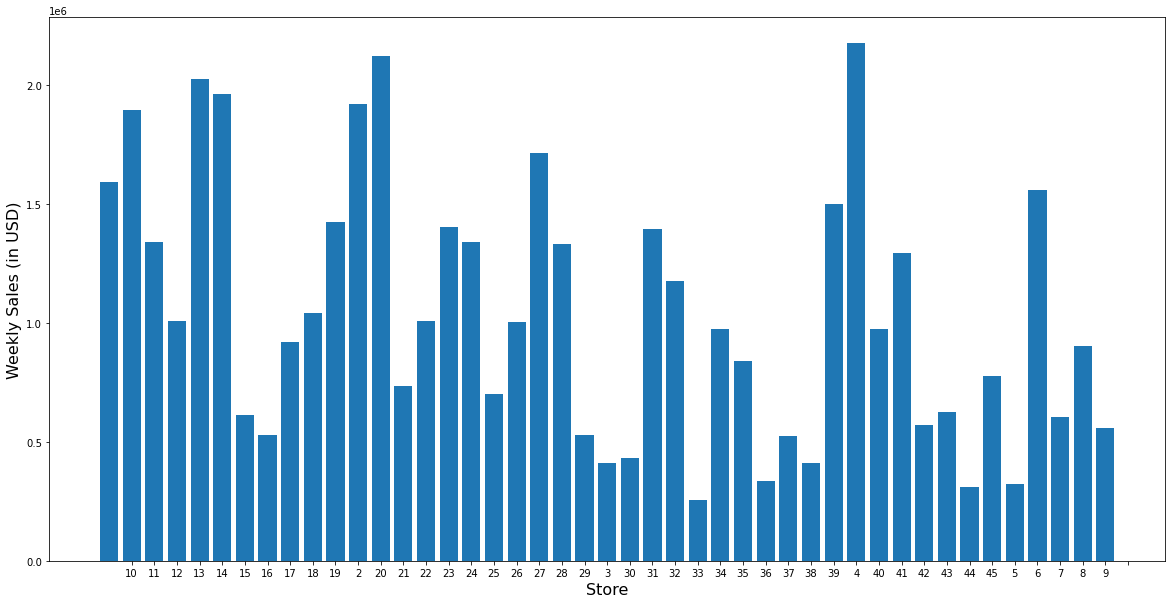

In [15]:
#average weekly sales by store
stores = train.groupby(['store_id']).agg({'weekly_sales': ['mean']})

plt.figure(figsize=(20, 10))
plt.bar(stores.index,stores['weekly_sales']['mean'])
plt.xticks(np.arange(1, 46, step=1))
plt.ylabel('Weekly Sales (in USD)', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

<AxesSubplot:xlabel='store_type', ylabel='store_size'>

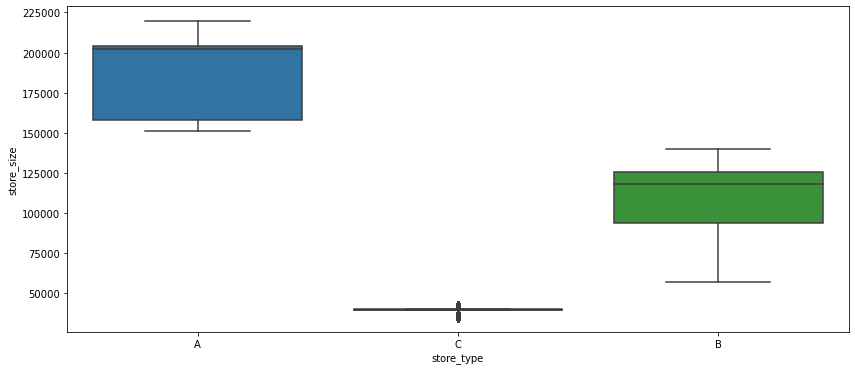

In [16]:
#visualize store_type by store_size
plt.figure(figsize=(14, 6))
sns.boxplot(x='store_type', y='store_size', data=train)

### Takeaways:
- Store A: appears to be only larger stores
- Store B: appear to be midsized stores
- Store C: appears to be only smaller stores

- outliers were addressed (store 3, store 5, store 33, store 36 were classified incorrectly)

<AxesSubplot:xlabel='store_type', ylabel='weekly_sales'>

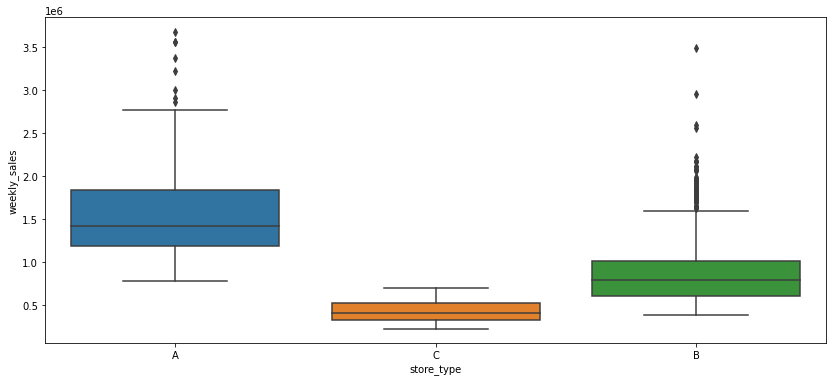

In [17]:
#visualize stores and weekly sales
plt.figure(figsize=(14,6))
sns.boxplot(x='store_type', y='weekly_sales', data=train)

<AxesSubplot:xlabel='store_type', ylabel='unemployment'>

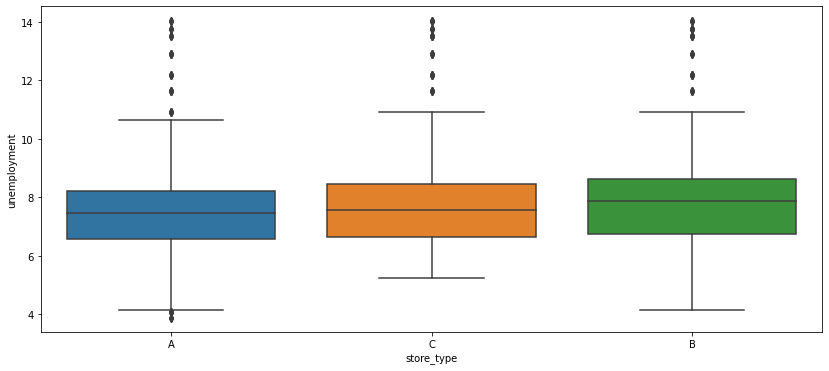

In [18]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.boxplot(x='store_type', y='unemployment', data=train)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

store_id
1     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
14    AxesSubplot(0.125,0.125;0.775x0.755)
15    AxesSubplot(0.125,0.125;0.775x0.755)
16    AxesSubplot(0.125,0.125;0.775x0.755)
17    AxesSubplot(0.125,0.125;0.775x0.755)
18    AxesSubplot(0.125,0.125;0.775x0.755)
19    AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
20    AxesSubplot(0.125,0.125;0.775x0.755)
21    AxesSubplot(0.125,0.125;0.775x0.755)
22    AxesSubplot(0.125,0.125;0.775x0.755)
23    AxesSubplot(0.125,0.125;0.775x0.755)
24    AxesSubplot(0.125,0.125;0.775x0.755)
25    AxesSubplot(0.125,0.125;0.775x0.755)
26    AxesSubplot(0.125,0.125;0.775x0.755)
27    AxesSubplot(0.125,0.125;0.775x0.755)
28    AxesSubplot(0.125,0.125;0.775x0.755)
29    AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
30

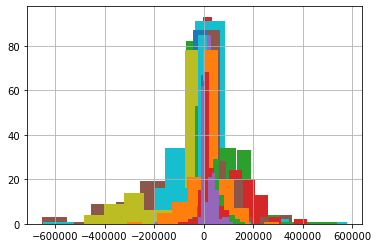

In [20]:
df.groupby('store_id').sales_delta_yearly.hist()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   store_id            6435 non-null   object 
 1   weekly_sales        6435 non-null   float64
 2   holiday_flag        6435 non-null   int64  
 3   temperature         6435 non-null   int64  
 4   fuel_price          6435 non-null   float64
 5   CPI                 6435 non-null   float64
 6   unemployment        6435 non-null   float64
 7   store_type          6435 non-null   object 
 8   store_size          6435 non-null   int64  
 9   month               6435 non-null   object 
 10  year                6435 non-null   int64  
 11  quarter             6435 non-null   int64  
 12  weekday             6435 non-null   object 
 13  week_of_year        6435 non-null   int64  
 14  deflated_series     6435 non-null   float64
 15  sales_delta_weekly  6435 non-null   f

<AxesSubplot:xlabel='fuel_price', ylabel='temperature'>

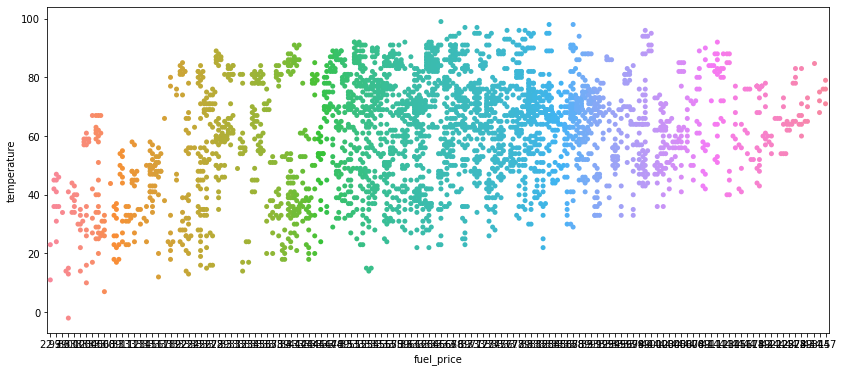

In [22]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='fuel_price', y='temperature', data=train)

<AxesSubplot:xlabel='fuel_price', ylabel='weekly_sales'>

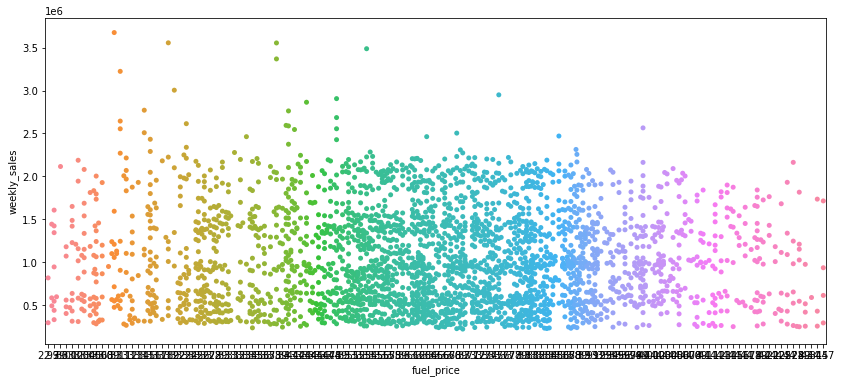

In [23]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='fuel_price', y='weekly_sales', data=train)

<AxesSubplot:xlabel='week_of_year', ylabel='weekly_sales'>

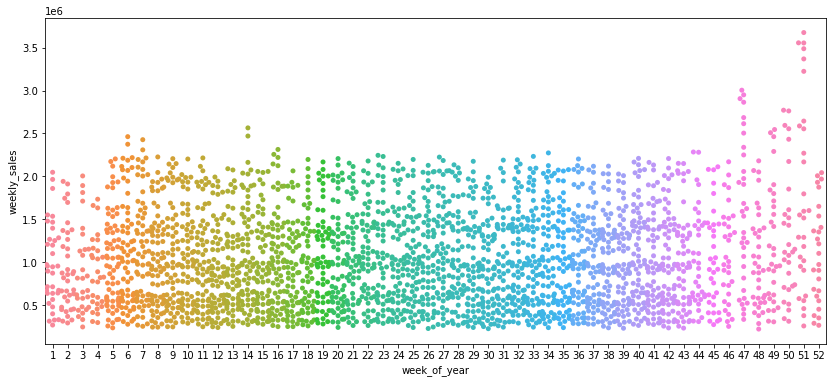

In [24]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='week_of_year', y='weekly_sales', data=train)

<AxesSubplot:xlabel='season', ylabel='weekly_sales'>

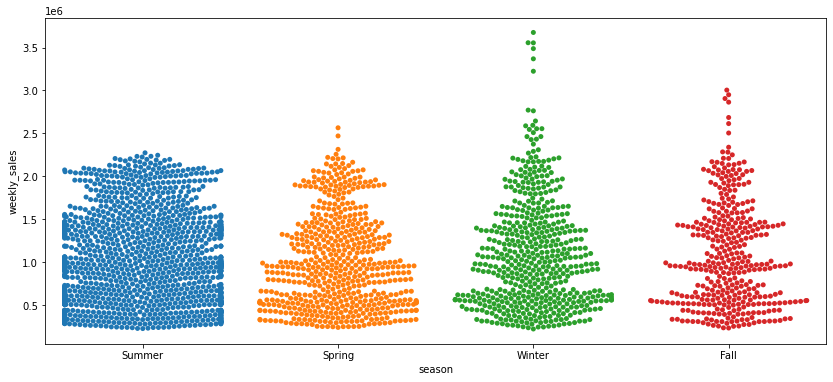

In [25]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='season', y='weekly_sales', data=train)

<AxesSubplot:xlabel='month', ylabel='weekly_sales'>

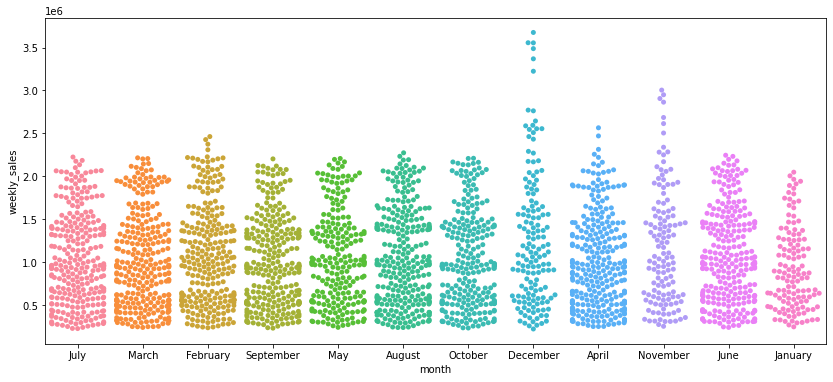

In [26]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='month', y='weekly_sales', data=train)

In [27]:
walmart = train.corr()
walmart

,weekly_sales,holiday_flag,temperature,fuel_price,CPI,unemployment,store_size,year,quarter,week_of_year,...,gas_delta_weekly,gas_delta_yearly,pre_christmas,tax_season,last_year_sales,last_week_sales,christmas,labor_day,super_bowl,thanksgiving
weekly_sales,1.000000,0.053487,-0.064931,-0.023791,-0.059325,-0.141024,0.818513,-0.021324,0.058808,0.067913,...,-0.031369,-0.021620,0.129189,-0.013025,0.986569,0.961801,0.009085,-0.002723,0.014614,0.099089
holiday_flag,0.053487,1.000000,-0.145959,-0.154513,-0.005149,0.000752,0.006120,-0.066978,0.048399,0.086516,...,0.044404,-0.008675,-0.037971,-0.057822,0.041507,0.051933,0.362154,0.567446,0.576588,0.408507
temperature,-0.064931,-0.145959,1.000000,0.289815,0.191503,0.103613,-0.101705,0.067961,0.274265,0.277490,...,-0.167005,0.009244,-0.179707,-0.096744,-0.066654,-0.060964,-0.130113,0.115524,-0.219761,-0.074336
fuel_price,-0.023791,-0.154513,0.289815,1.000000,-0.366323,0.193836,-0.002245,0.211609,0.013659,0.013078,...,0.072231,0.148624,-0.177828,0.131680,-0.013662,-0.024397,-0.128309,0.066854,-0.181990,-0.081559
CPI,-0.059325,-0.005149,0.191503,-0.366323,1.000000,-0.247392,0.000888,0.050171,0.005029,0.004370,...,-0.010594,-0.066923,-0.001994,0.004838,-0.066327,-0.053807,0.004010,-0.003041,-0.002687,-0.007555
unemployment,-0.141024,0.000752,0.103613,0.193836,-0.247392,1.000000,-0.094584,-0.184417,-0.054360,-0.046796,...,0.018315,0.180040,-0.010148,-0.005989,-0.116035,-0.141956,-0.021592,0.001611,0.004538,0.012385
store_size,0.818513,0.006120,-0.101705,-0.002245,0.000888,-0.094584,1.000000,0.001648,-0.007186,-0.005691,...,-0.006814,-0.001995,-0.002184,-0.004963,0.807910,0.820447,0.017713,0.000336,-0.003952,0.003480
year,-0.021324,-0.066978,0.067961,0.211609,0.050171,-0.184417,0.001648,1.000000,-0.237809,-0.243808,...,0.073580,-0.813722,-0.136480,0.012990,-0.047527,-0.018738,-0.090862,0.010135,0.010224,-0.102491
quarter,0.058808,0.048399,0.274265,0.013659,0.005029,-0.054360,-0.007186,-0.237809,1.000000,0.961520,...,-0.308945,0.070676,0.216008,-0.089776,0.052313,0.056245,0.143808,0.081914,-0.208212,0.162214
week_of_year,0.067913,0.086516,0.277490,0.013078,0.004370,-0.046796,-0.005691,-0.243808,0.961520,1.000000,...,-0.336058,0.059202,0.265811,-0.180713,0.061816,0.073055,0.187486,0.117916,-0.215212,0.171922


In [28]:
#this shows correlation with sales
wal_corr = walmart['weekly_sales'].sort_values(ascending=False)
wal_corr

weekly_sales          1.000000
last_year_sales       0.986569
last_week_sales       0.961801
deflated_series       0.904856
store_size            0.818513
sales_delta_weekly    0.154295
pre_christmas         0.129189
sales_delta_yearly    0.104848
thanksgiving          0.099089
week_of_year          0.067913
quarter               0.058808
holiday_flag          0.053487
super_bowl            0.014614
christmas             0.009085
labor_day            -0.002723
tax_season           -0.013025
year                 -0.021324
gas_delta_yearly     -0.021620
fuel_price           -0.023791
gas_delta_weekly     -0.031369
CPI                  -0.059325
temperature          -0.064931
unemployment         -0.141024
Name: weekly_sales, dtype: float64

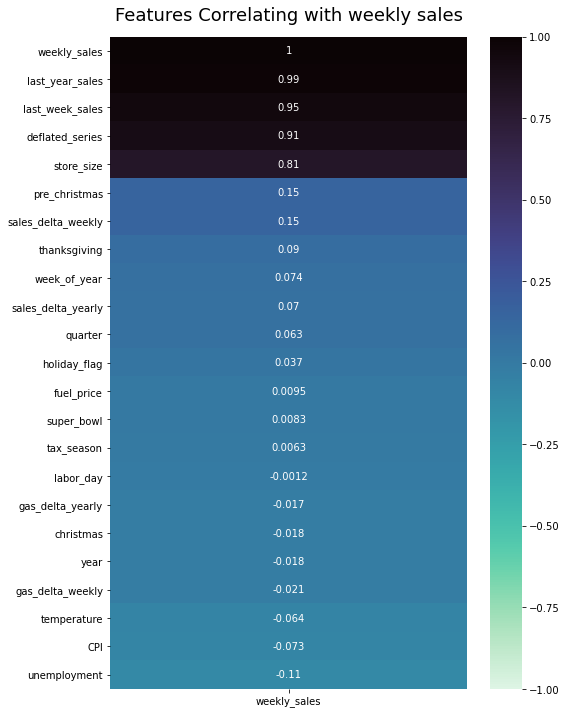

In [29]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['weekly_sales']].sort_values(by='weekly_sales', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with weekly sales', fontdict={'fontsize':18}, pad=16);

<hr style="border:2px solid black"> </hr>

## Hypothesis 1: Pearson's (cont vs cont)
$H_0$: There is no correlation between weekly_sales and store_size

$H_a$: There is a correlation between weekly_sales and store_size


In [30]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

In [31]:
x= train.weekly_sales
y= train.store_size

In [32]:
r, p = stats.pearsonr(x,y)
r,p

(0.8185125014901132, 0.0)

In [33]:
p < alpha

True

In [34]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.818513 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


### Takeaways:
- We rejected our null hypothesis, thus indicating that there is a correlation between weekly sales and store size

<hr style="border:2px solid black"> </hr>

## Hypothesis 2: Pearson's (cont vs cont)
$H_0$: There is no correlation between weekly_sales and temperature

$H_a$: There is a correlation between weekly_sales and temperature

In [35]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

x= train.weekly_sales
y= train.temperature

In [36]:
r, p = stats.pearsonr(x,y)
r,p

(-0.06493087292522058, 0.0005047349808810571)

In [37]:
p < alpha

True

In [38]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of -0.064931 and a statistical certainty p of 0.000505
Because p 0.000505 < α  0.050000, we can reject our null hypothesis


### Takeaways:
- We rejected our null hypothesis, thus indicating that there is a correlation between weekly sales and temperature

<hr style="border:1px solid black"> </hr>

## Hypothesis 3: Pearson's (cont vs cont)
$H_0$: There is no correlation between weekly_sales and fuel_prices

$H_a$: There is a correlation between weekly_sales and fuel_prices

In [39]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

x= train.weekly_sales
y= train.fuel_price

In [40]:
r, p = stats.pearsonr(x,y)
r,p

(-0.023790525222855775, 0.20292891668126112)

In [41]:
p < alpha

False

In [42]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} > α  {alpha:4f}, we fail to reject our null hypothesis')

We calculate a pearson r of -0.023791 and a statistical certainty p of 0.202929
Because p 0.202929 > α  0.050000, we fail to reject our null hypothesis


### Takeaways:
- We failed to reject our null hypothesis, thus indicating that there is no correlation between weekly sales and fuel prices

<hr style="border:1px solid black"> </hr>

## Hypothesis 4: T-Test (cont vs discrete)¶
$H_0$: There is no relationship between weekly_sales and week_of_year

$H_a$: There is a relationship between weekly_sales and week_of_year

In [43]:
#set alpha
alpha = .05

In [44]:
# sample size, must be more then 30 to meet assumption
train.weekly_sales.count(), train.week_of_year.count()

(2866, 2866)

In [45]:
#check variance
train.weekly_sales.var(), train.week_of_year.var()

#this shows not equal varient

(317139027538.5311, 186.13694515588054)

In [46]:
#t-test on entire train set
t, p = stats.ttest_ind(train.weekly_sales,train.week_of_year, equal_var=False)
t,p

(99.2719289373685, 0.0)

In [47]:
p <alpha

True

In [48]:
print(f'We calculate a t of {t:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we reject our null hypothesis')

We calculate a t of 99.271929 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we reject our null hypothesis


### Takeaways:
- We rejected our null hypothesis, thus indicating that there is a correlation between weekly sales and week of the year

<hr style="border:2px solid black"> </hr>

## Hypothesis 5: Pearson's (cont vs cont)
$H_0$: There is no correlation between weekly_sales and last_week_sales

$H_a$: There is a correlation between weekly_sales and last_week_sales

In [49]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

x= train.weekly_sales
y= train.last_week_sales

In [50]:
r, p = stats.pearsonr(x,y)
r,p

(0.9618008913159304, 0.0)

In [51]:
p < alpha

True

In [52]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.961801 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


### Takeaways:
- We rejected our null hypothesis, thus indicating that there is a correlation between weekly sales and sales from the previous week.

<hr style="border:2px solid black"> </hr>

# Clustering
- we are clustering in order to attempt to find regions

### Cluster 1: CPI & Fuel Prices

In [53]:
#chose variables for this possible cluster
X = train[['CPI', 'fuel_price']]
#tke a look
X.head()

,CPI,fuel_price
Date,,
2011-07-08,186.032,3.71
2011-03-25,192.196,3.41
2012-02-10,211.764,3.41
2011-02-11,133.261,3.26
2012-09-28,131.043,3.97


In [54]:
# Scale the X
scaler = MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

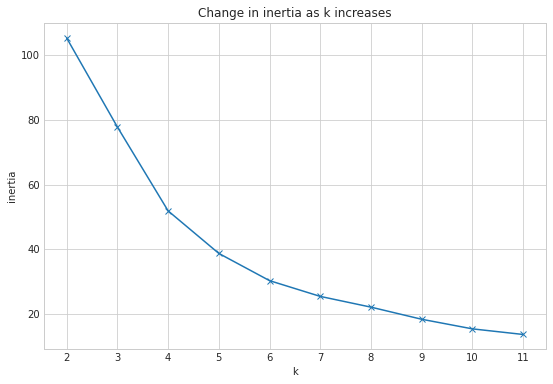

In [55]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [56]:
def scatter_plots(X_scaled, col_name= 'column_one', col_name_two= 'column_two'):
    '''
    This function takes in two columns and 
    creates a range of scatter plots based on varying k values
    '''
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    for ax, k in zip(axs.ravel(), range(2, 6)):
        clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
        ax.scatter(X_scaled[col_name], X_scaled[col_name_two], c=clusters)
        ax.set(title='k = {}'.format(k), xlabel=col_name, ylabel=col_name_two)


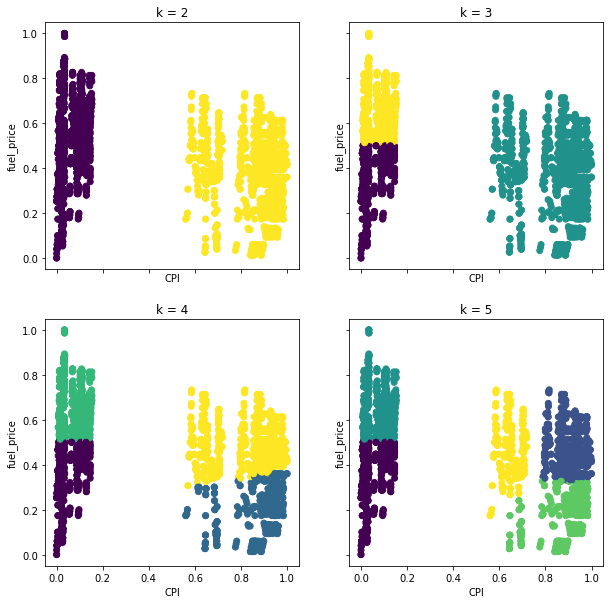

In [57]:
#use scatter_plot function 
#this will show you different clusters with varying k values
scatter_plots(X_scaled, col_name= 'CPI', col_name_two= 'fuel_price')

### Cluster 1 Takeaways
- k = 4 appears to show best results
- cluster 1 (blue): lower CPI, low fuel prices
- cluster 2 (green): high fuel prices, low CPI
- cluster 3 (purple): high CPI, low fuel prices
- cluster 4 (yellow): high CPI, high fuel prices

<hr style="border:1px solid black"> </hr>

## Cluster 2: CPI & Unemployment

In [58]:
#chose variables for this possible cluster
X2 = train[['CPI', 'unemployment']]
#tke a look
X2.head()

,CPI,unemployment
Date,,
2011-07-08,186.032,8.625
2011-03-25,192.196,7.241
2012-02-10,211.764,9.653
2011-02-11,133.261,5.114
2012-09-28,131.043,10.926


In [59]:
# Scale the X
scaler = MinMaxScaler().fit(X2)
X2_scaled = pd.DataFrame(scaler.transform(X2), columns= X2.columns).set_index([X2.index.values])

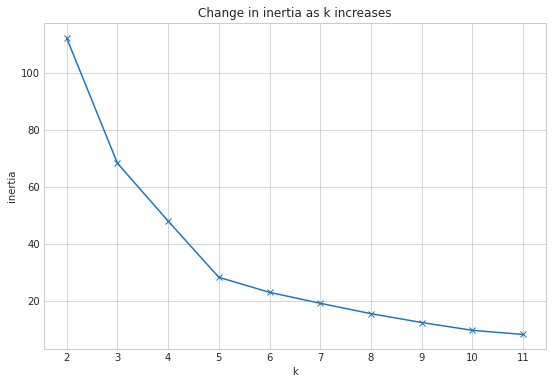

In [60]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

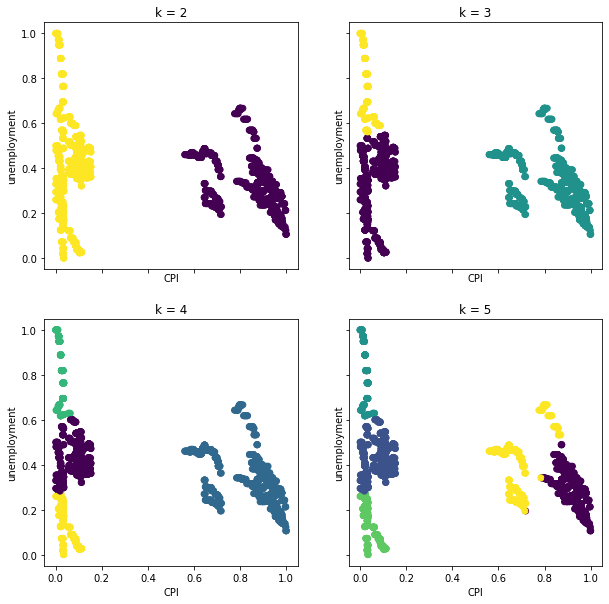

In [61]:
#use scatter_plot function 
#this will show you different clusters with varying k values
scatter_plots(X2_scaled, col_name= 'CPI', col_name_two= 'unemployment')

### Cluster 2 Takeaways
- k = 3 appears to show best results
- cluster 1 (purple): low unemployment, low cpi
- cluster 2 (yellow): high unemployment, low cpi
- cluster 3 (teal): high cpi, mid unemployment

<hr style="border:1px solid black"> </hr>

## Cluster 3: Temperature & Unemployment

In [62]:
#chose variables for this possible cluster
X3 = train[['temperature', 'unemployment']]
#tke a look
X3.head()

,temperature,unemployment
Date,,
2011-07-08,77,8.625
2011-03-25,41,7.241
2012-02-10,46,9.653
2011-02-11,21,5.114
2012-09-28,81,10.926


In [63]:
# Scale the X
scaler = MinMaxScaler().fit(X3)
X3_scaled = pd.DataFrame(scaler.transform(X3), columns= X3.columns).set_index([X3.index.values])

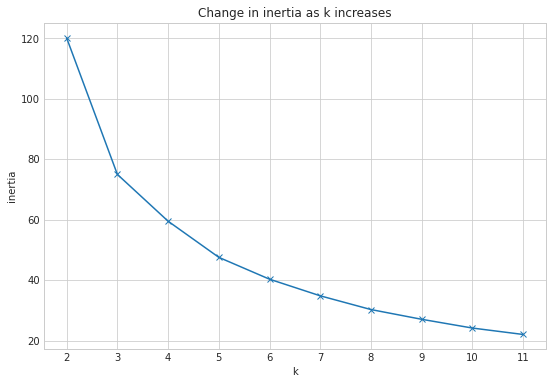

In [64]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

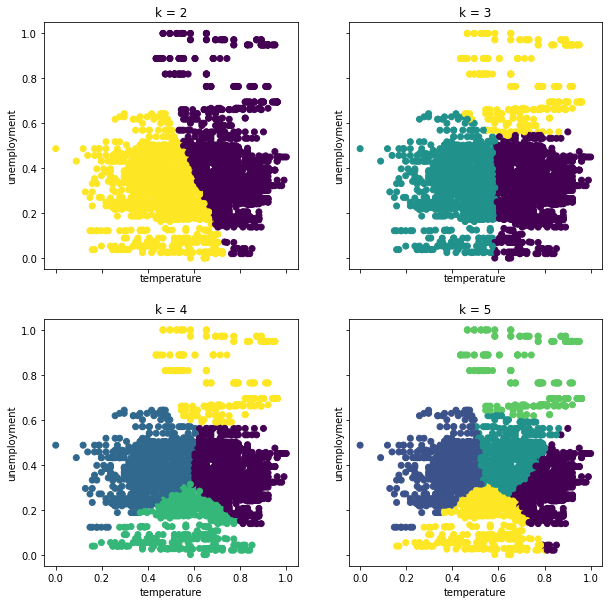

In [65]:
#use scatter_plot function 
#this will show you different clusters with varying k values
scatter_plots(X3_scaled, col_name= 'temperature', col_name_two= 'unemployment')

### Cluster 3 Takeaways
- k = 3 appears to show best results
- cluster 1 (green): lower temps, low- mid unemployment
- cluster 2 (purple): high temp, low-mid unemployment
- cluster 3 (yellow): high unemployment, mid-high temps 

<hr style="border:1px solid black"> </hr>

## Cluster 4: Temperature & Gas Prices

In [66]:
#chose variables for this possible cluster
X4 = train[['temperature', 'fuel_price']]
#tke a look
X4.head()

,temperature,fuel_price
Date,,
2011-07-08,77,3.71
2011-03-25,41,3.41
2012-02-10,46,3.41
2011-02-11,21,3.26
2012-09-28,81,3.97


In [67]:
# Scale the X
scaler = MinMaxScaler().fit(X4)
X4_scaled = pd.DataFrame(scaler.transform(X4), columns= X4.columns).set_index([X4.index.values])

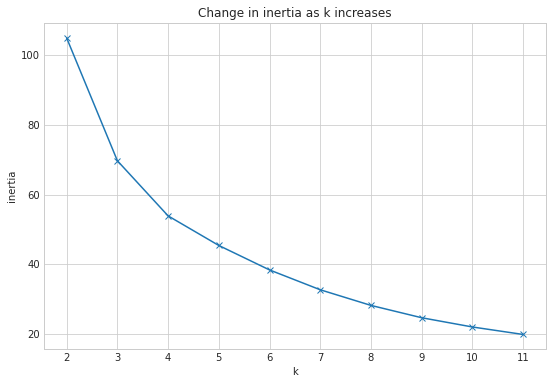

In [68]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X4_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

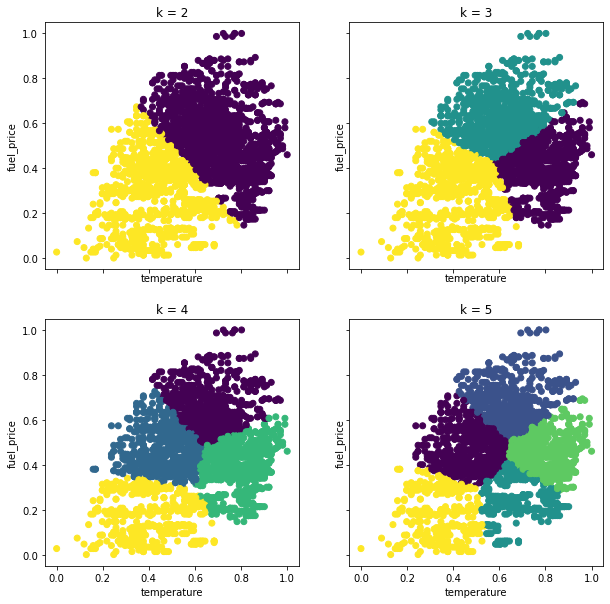

In [69]:
#use scatter_plot function 
#this will show you different clusters with varying k values
scatter_plots(X4_scaled, col_name= 'temperature', col_name_two= 'fuel_price')

### Cluster 4 Takeaways
- k = 4 appears to show best results
- cluster 1 (green): lower temps, low fuel prices
- cluster 2 (blue): high temp, low fuel prices
- cluster 3 (yellow): high fuel prices, low temps 
- cluster 4 (purple): high temps, high fuel prices

<hr style="border:2px solid black"> </hr>

# Modeling

In [70]:
#set features
#we do not want to include all columns in this because it could cause overfitting
features = ['store_size', 'unemployment', 'week_of_year', 'last_week_sales', 'last_year_sales']

In [71]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame({'actual': y_train})
y_test = pd.DataFrame({'actual': y_test})

## Baseline

In [72]:
#create the baseline using mean of all sales
baseline= y_train['actual'].mean()

In [73]:
#create column called baseline to compare
y_train['baseline'] = baseline

In [74]:
#calculate RMSE for baseline model
rmse_baseline_train= math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

In [75]:
#create a dataframe to make data easier to visualize/understand
metric_df = pd.DataFrame(data=[{
    'model': "Baseline (using mean)",
    'rmse_train': round(rmse_baseline_train, 2)
}])

metric_df
#we now have out baseline model to work off of

,model,rmse_train
0,Baseline (using mean),563052.73


## Baseline 2

In [76]:
#baseline version 2 using last years sales
baseline2 = train['last_year_sales']

In [77]:
#prediction
#create column called baseline to compare
y_train['last_year_baseline'] = baseline2

In [78]:
#calculate RMSE for baseline model
rmse_baseline2_train= math.sqrt(mean_squared_error(y_train.actual, y_train.last_year_baseline))

In [79]:
#create a dataframe to make data easier to visualize/understand
metric_df = metric_df.append(
    {
    'model': "Baseline (using last year's sales)",
    'rmse_train': round(rmse_baseline2_train, 2),
    }, ignore_index=True)

metric_df

,model,rmse_train
0,Baseline (using mean),563052.73
1,Baseline (using last year's sales),92956.53


## OLS Model

In [80]:
#ordinary least squares
#create the model 
model1 = LinearRegression(normalize=True)

#fit the model
model1.fit(X_train[features], y_train.actual)

LinearRegression(normalize=True)

In [81]:
# predict train
y_train['sales_pred_lm'] = model1.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.sales_pred_lm)**(1/2)

In [82]:
#create visual to see baseline vs LinearRegression model
metric_df = metric_df.append(
    {
    'model': 'Model 1: OLS',
    'rmse_train': round(rmse_train, 2),
    }, ignore_index=True)

metric_df

,model,rmse_train
0,Baseline (using mean),563052.73
1,Baseline (using last year's sales),92956.53
2,Model 1: OLS,77161.65


## Lasso Lars

In [83]:
# create the model object
model2 = LassoLars(alpha= 2)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
model2.fit(X_train[features], y_train.actual)

# predict train
y_train['sales_pred_lars'] = model2.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.sales_pred_lars)**(1/2)

In [84]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Model 2: LassoLars (alpha 2)',
    'rmse_train': round(rmse_train,2),
    }, ignore_index=True)

metric_df

,model,rmse_train
0,Baseline (using mean),563052.73
1,Baseline (using last year's sales),92956.53
2,Model 1: OLS,77161.65
3,Model 2: LassoLars (alpha 2),77161.86


## Polynomial Regression

In [85]:
#make the polynomial features to get a new set of features
model3 = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features
X_train_degree2 = model3.fit_transform(X_train[features])

In [91]:
#create the model
lm2 = LinearRegression(normalize=True)

#fit the mode
lm2.fit(X_train_degree2, y_train.actual)

#use the model
y_train['sale_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_model3 = mean_squared_error(y_train.actual, y_train.sale_pred_lm2) ** (1/2)

In [92]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Model 3: Polynomial Regression (degree=2)',
    'rmse_train': round(rmse_train_model3,2),
    }, ignore_index=True)

metric_df

,model,rmse_train
0,Baseline (using mean),563052.73
1,Baseline (using last year's sales),92956.53
2,Model 1: OLS,77161.65
3,Model 2: LassoLars (alpha 2),77161.86
4,Model 3: Polynomial Regression (degree=2),68980.27


### Takeaways
- 2nd Degree Polynomial Regression model out performed the baseline (using last year's sales) by 26.79% on the train set